In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from skimage import io, exposure, color
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from PIL import Image, ImageEnhance
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_images(low_light_dir, enhanced_dir, num_images=5):
    low_light_images = os.listdir(low_light_dir)[:num_images]
    enhanced_images = os.listdir(enhanced_dir)[:num_images]
    
    plt.figure(figsize=(15, 10))

    for i, img_name in enumerate(low_light_images, 1):
        image_path = os.path.join(low_light_dir, img_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        plt.subplot(2, num_images, i)
        plt.imshow(image)
        plt.title(f'Low Light {i}')
        plt.axis('off')

    for i, img_name in enumerate(enhanced_images, 1):
        image_path = os.path.join(enhanced_dir, img_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        plt.subplot(2, num_images, num_images + i)
        plt.imshow(image)
        plt.title(f'Enhanced {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
low_light_dir = 'lol-dataset/lol_dataset/our485/low'
enhanced_dir = 'lol-dataset/lol_dataset/our485/high'

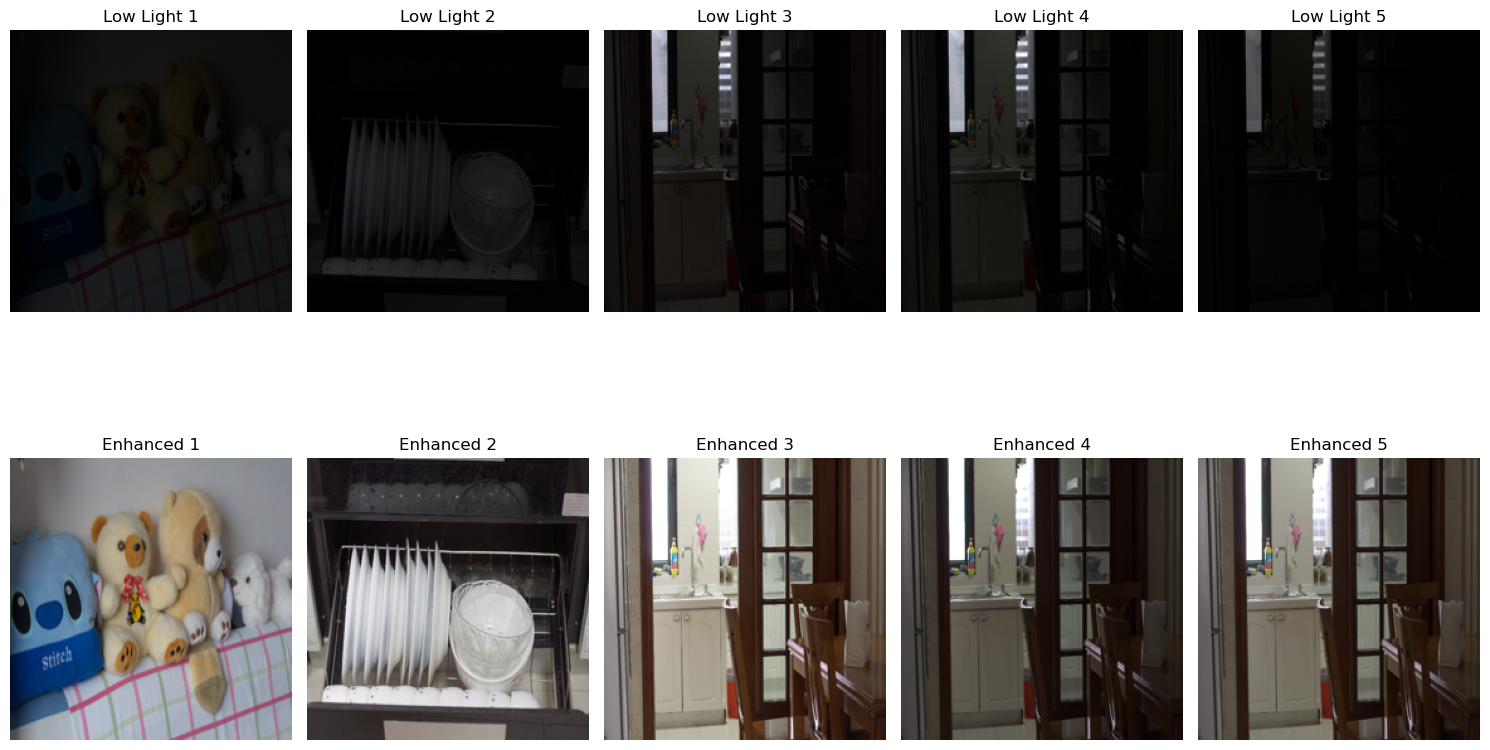

In [4]:
plot_images(low_light_dir, enhanced_dir, num_images=5)

# Pre-processing

In [10]:
def preprocess_lowlight_images(image_dir):

    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    processed_images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image = ImageOps.autocontrast(image)
        image_resized = image.resize((600, 400))
        image_array = np.array(image_resized) / 255.0
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        processed_images.append(image_tensor)

    return np.array(processed_images)

In [11]:
low_light_images = preprocess_lowlight_images(low_light_dir)

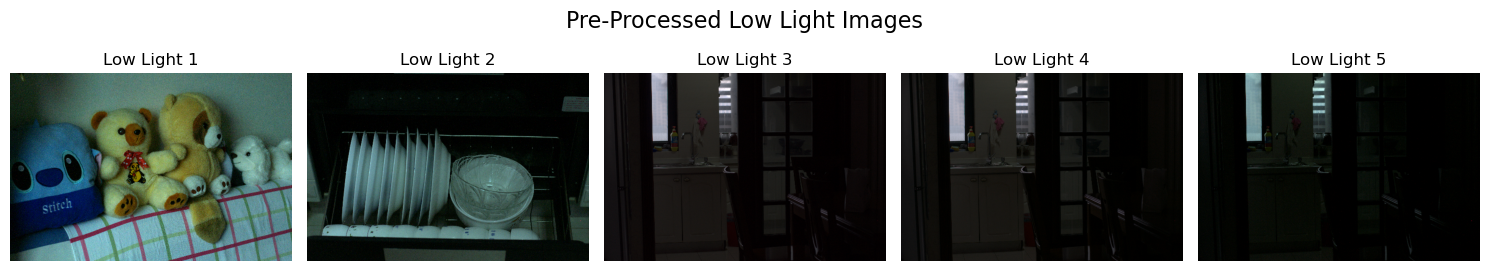

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()
fig.suptitle('Pre-Processed Low Light Images', fontsize=16)
for i, ax in enumerate(axes[:5]):
    ax.imshow(low_light_images[i])
    ax.set_title(f'Low Light {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=1.3)
plt.show()

In [13]:
def process_enhanced_images(image_dir):
    
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    processed_images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_resized = image.resize((600, 400))
        image_array = np.array(image_resized) / 255.0
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        processed_images.append(image_tensor)

    return np.array(processed_images)

In [14]:
enhanced_images = process_enhanced_images(enhanced_dir)

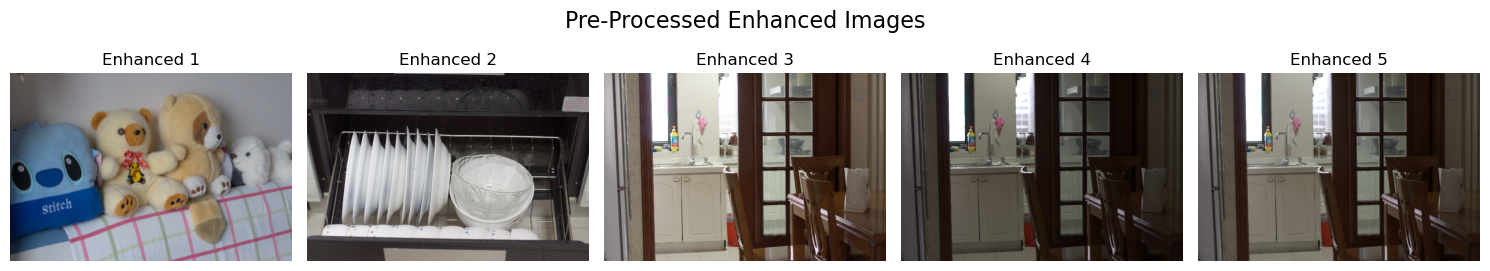

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()
fig.suptitle('Pre-Processed Enhanced Images', fontsize=16)
for i, ax in enumerate(axes[:5]):
    ax.imshow(enhanced_images[i])
    ax.set_title(f'Enhanced {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=1.3)
plt.show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(low_light_images, enhanced_images, test_size=0.2, random_state=18)

# Modelling

In [17]:
def build_autoencoder_v2(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder - using convolutional layers with strides for downsampling
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)  # Downsample
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(conv1)  # Further downsample
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(conv2)  # Further downsample

    # Bottleneck - we can add some convolutional layers or a dense layer if needed
    bottleneck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)  # Bottleneck layer

    # Decoder - using transposed convolutions for upsampling
    up1 = tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(bottleneck)  # Upsample
    up2 = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(up1)  # Upsample
    up3 = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(up2)  # Upsample

    # Output layer - producing the final output with 3 channels (RGB)
    outputs = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(up3)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
autoencoder_v2 = build_autoencoder_v2(input_shape=(400, 600, 3))
autoencoder_v2.compile(optimizer='adam', loss='mse')

In [19]:
autoencoder_v2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 300, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 150, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 75, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 75, 256)       295168    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 150, 128)    295040    
 nspose)                                                         
                                                             

In [20]:
history = autoencoder_v2.fit(x_train, y_train, epochs=25, batch_size=4, validation_data=(x_test, y_test))

Epoch 1/25
97/97 [==============================] - 135s 1s/step - loss: 0.0377 - val_loss: 0.0334
Epoch 2/25
97/97 [==============================] - 130s 1s/step - loss: 0.0303 - val_loss: 0.0274
Epoch 3/25
97/97 [==============================] - 130s 1s/step - loss: 0.0273 - val_loss: 0.0263
Epoch 4/25
97/97 [==============================] - 130s 1s/step - loss: 0.0265 - val_loss: 0.0253
Epoch 5/25
97/97 [==============================] - 131s 1s/step - loss: 0.0260 - val_loss: 0.0241
Epoch 6/25
97/97 [==============================] - 130s 1s/step - loss: 0.0263 - val_loss: 0.0246
Epoch 7/25
97/97 [==============================] - 129s 1s/step - loss: 0.0268 - val_loss: 0.0293
Epoch 8/25
97/97 [==============================] - 131s 1s/step - loss: 0.0260 - val_loss: 0.0236
Epoch 9/25
97/97 [==============================] - 137s 1s/step - loss: 0.0265 - val_loss: 0.0247
Epoch 10/25
97/97 [==============================] - 128s 1s/step - loss: 0.0259 - val_loss: 0.0248
Epoch 11/

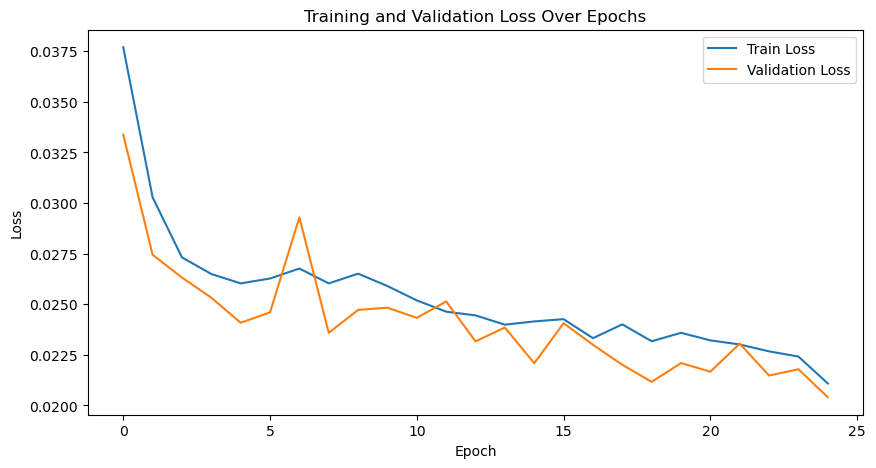

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()